# 学習方法の例

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

In [58]:
import os
# import sqlite3
import configparser
import mlflow
import mlflow.sklearn

In [59]:
cfg = configparser.ConfigParser()
cfg.read('./config.ini', encoding='utf-8')
# 各種パスを指定
# DB_PATH = cfg['Path']['db_path']

['./config.ini']

In [60]:
# %% エクスペリメントの作成
# Artifactストレージの場所を指定
ARTIFACT_LOCATION = cfg['Path']['artifact_location']
# Experimentの生成
EXPERIMENT_NAME = 'cnn_tuning'
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:  # 当該Experiment存在しないとき、新たに作成
    experiment_id = mlflow.create_experiment(
                            name=EXPERIMENT_NAME,
                            artifact_location=ARTIFACT_LOCATION)
else: # 当該Experiment存在するとき、IDを取得
    experiment_id = experiment.experiment_id

## データを読む1

In [61]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [62]:
# 正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')
# print(train_data)

In [63]:
# 配列形式変更
train_data = train_data.reshape(-1, 28*28)
print("train_data.shape=", train_data.shape)

train_data.shape= (3000, 784)


## trainとtestに分割する

In [64]:
X_train_all, X_test, y_train_all, y_test = train_test_split(train_data, train_label, 
                                                    test_size=0.3, random_state=1234,
                                                    shuffle=True
                                                   )

print(X_train_all.shape, X_test.shape)

(2100, 784) (900, 784)


In [65]:
X_train = X_train_all
y_train = y_train_all
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2100, 784) (900, 784)
(2100, 15) (900, 15)


## 学習

### 配列形状の変形

In [66]:
print(f'trainの形状：{X_train.shape}')
print(f'train_labelの形状：{y_train.shape}')
print(f'testの形状：{X_test.shape}')
print(f'test_labelの形状：{y_test.shape}')

trainの形状：(2100, 784)
train_labelの形状：(2100, 15)
testの形状：(900, 784)
test_labelの形状：(900, 15)


In [67]:
train = X_train.reshape(-1, 1, 28, 28)
test = X_test.reshape(-1, 1, 28, 28)

In [77]:
print(f'trainの形状：{train.shape}')
print(f'testの形状：{test.shape}')

trainの形状：(2100, 1, 28, 28)
testの形状：(900, 1, 28, 28)


### ミニバッチ学習

In [78]:
### SimpleConvNetクラスの実装
from collections import OrderedDict
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss
from common.gradient import numerical_gradient
from common.optimizer import RMSProp

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=100, output_size=10, weight_init_std=0.01, batch_size=100):
        """
        input_size : tuple, 入力の配列形状(チャンネル数、画像の高さ、画像の幅)
        conv_param : dict, 畳み込みの条件
        pool_param : dict, プーリングの条件
        hidden_size : int, 隠れ層のノード数
        output_size : int, 出力層のノード数
        weight_init_std ： float, 重みWを初期化する際に用いる標準偏差
        """
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        # 4_6_を参考にすると、pool_output_size=out_h、
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        # Day3 p29を参考にすると、filter_num=FN, pool_output_size=OH=OW
        pool_output_pixel = filter_num * pool_output_size * pool_output_size # プーリング後のピクセル総数
        print("class初期化時の値", filter_num, filter_size, filter_pad, input_size, batch_size, weight_init_std)
        
        # 重みの初期化
        self.params = {}
        std = weight_init_std
        # Day3のp29において、filter_num=FN, input_dim[0]=C, filter_size=FH=FW
        self.params['W1'] = std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = std *  np.random.randn(pool_output_pixel, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std *  np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        # Day3 p20を参考に、畳み込み層→活性化関数→プーリング層→全結合層→活性化関数→全結合層→ソフトマックス関数
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """
        損失関数
        x : 入力データ
        t : 教師データ
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        print("SimpleConvNet.accuracyのbatch_size", batch_size)
        # batch_size = self.batch_size
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        Parameters
        ----------
        x : 入力データ
        t : 教師データ
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [80]:
# データを間引く
# X_train = X_train_all[:1000,:]
# y_train = y_train_all[:1000,:]
# x = train[:1000,:]; t = y_train[:1000,:] # x: 訓練データ、t: テストデータ
x = train; t = y_train
x = x.reshape(-1,1,28,28) # 配列形式の変形

def model_train(epochs, batch_size, filter_num, filter_size, weight_init_std):
    optimizer = RMSProp(lr=0.01, rho=0.9)
    
    # 繰り返し回数
    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(int)

    # CNNのオブジェクト生成
    snet = SimpleConvNet(input_dim=(1, 28, 28), 
                         conv_param={'filter_num':filter_num, 'filter_size':filter_size, 'pad':0, 'stride':1},
                         pool_param={'pool_size':2, 'pad':0, 'stride':2},
                         hidden_size=100, output_size=15, weight_init_std=weight_init_std, batch_size=batch_size)

    train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

    for epoch in range(epochs):
        if np.mod(epoch,1)==0: print("epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]; t_train = t[mask]
            
            # 勾配の計算 (誤差逆伝播法を用いる)
            grads = snet.gradient(x_train, t_train)

            # 更新
            optimizer.update(snet.params, grads)

        ## 学習経過の記録
        # 訓練データおよびテストデータにおけるloss
        train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

        # 訓練データおよびテストデータにて精度を確認
        train_accuracy.append(snet.accuracy(x, t, batch_size)); test_accuracy.append(snet.accuracy(test, y_test, batch_size))
        print(snet.accuracy(x, t, batch_size), snet.accuracy(test, y_test, batch_size))
    return snet, train_accuracy, test_accuracy, train_loss, test_loss

In [81]:
# x = train[:1000,:]; t = y_train[:1000,:]

# x = x.reshape(-1,1,28,28) # 配列形式の変形

# epochs = 10
# batch_size = 100

# optimizer = RMSProp(lr=0.01, rho=0.9)

# # 繰り返し回数
# xsize = x.shape[0]
# iter_num = np.ceil(xsize / batch_size).astype(int)

# # CNNのオブジェクト生成
# snet = SimpleConvNet(input_dim=(1, 28, 28), 
#                      conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
#                      pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                      hidden_size=100, output_size=15, weight_init_std=0.01)

# train_loss = []; test_loss = []; train_accuracy = []; test_accuracy = []

# for epoch in range(epochs):
#     if np.mod(epoch,10)==0: print("epoch=%s"%epoch)

#     # シャッフル
#     idx = np.arange(xsize)
#     np.random.shuffle(idx)

#     for it in range(iter_num):
#         """
#         ランダムなミニバッチを順番に取り出す
#         """
#         print("it=", it)
#         mask = idx[batch_size*it : batch_size*(it+1)]

#         # ミニバッチの生成
#         x_train = x[mask]; t_train = t[mask]

#         # 勾配の計算 (誤差逆伝播法を用いる)
#         grads = snet.gradient(x_train, t_train)

#         # 更新
#         optimizer.update(snet.params, grads)

#     ## 学習経過の記録
#     # 訓練データおよびテストデータにおけるloss
#     train_loss.append(snet.loss(x,  t)); test_loss.append(snet.loss(test, y_test))

#     # 訓練データおよびテストデータにて精度を確認
#     train_accuracy.append(snet.accuracy(x, t)); test_accuracy.append(snet.accuracy(test, y_test))

In [82]:
# mlflowに記録
# epochs = 200
# batch_size = 32
# lr = 0.01
# random_seed = 1234
epochs = 100
batch_size = 100

filter_num = 30
filter_size = 5
weight_init_std = 0.01

mlflow.end_run()

# 管理IDを発行（コードの実行に対して）
with mlflow.start_run(experiment_id=experiment_id):
    trial = 0
    print("mlflow時点のbatch_size", batch_size)
    tnet, train_acc, test_acc, train_loss, test_loss = model_train(epochs, batch_size, filter_num, filter_size, weight_init_std)

    # 小数点以下３桁まで出力
    print(f"trial {trial}: batch_size={batch_size}, filter_num={filter_num},　train_accuracy={train_acc[-1]:.3}, test_accuracy={test_acc[-1]:.3}")

    # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
    mlflow.log_param("filter_num", filter_num)
    mlflow.log_param("filter_size", filter_size)
    mlflow.log_param("weight_init_std", weight_init_std)
    mlflow.log_metric("train_accuracy", train_acc[-1])
    mlflow.log_metric("test_accuracy", test_acc[-1])
    # mlflow.log_param("random_seed", random_seed)

    # mlflow.log_model(tnet, "model")

# mlflowを終了
mlflow.end_run()

mlflow時点のbatch_size 100
layers.RMSPropのrho 0.9
class初期化時の値 30 5 0 28 100 0.01
epoch=0
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=1
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=2
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=3
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=4
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=5
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=6
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=7
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=8
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=9
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 100
epoch=10
SimpleConvNet.accuracyのbatch_size 100
SimpleConvNet.accuracyのbatch_size 1

In [52]:
# mlflow.end_run()

In [53]:
# # mlflowに記録（グリッドサーチ）
# # 管理IDを発行（コードの実行に対して）
# experiment_id = 0
# with mlflow.start_run(experiment_id=experiment_id):
#     # ハイパーパラメータの試行水準
#     cand_batch_size = [16, 32]
#     cand_lr = [0.005, 0.01]

#     trial = 0
#     for batch_size in cand_batch_size:
#         for lr in cand_lr:
#             # 管理IDを発行（各パラメータ水準に対して）
#             with mlflow.start_run(experiment_id=experiment_id, nested=True):
#                 trial += 1
#                 tnet, train_accuracy, test_accuracy, train_loss, test_loss = model_train(epochs, batch_size, lr)
#                 # model, mse, R2 = train(n_estimators, max_depth)
#                 # 小数点以下３桁まで出力
#                 print(f"trial {trial}: batch_size={batch_size}, lr={lr}, \
#                       train_accuracy={train_accuracy[-1]:.3}, test_accuracy={test_accuracy[-1]:.3}")
#                 # 追加箇所
#                 # ハイパーパラメータ, 評価指標, 学習済みモデルをMLflowへ保存
#                 mlflow.log_param("batch_size", batch_size)
#                 mlflow.log_param("lr", lr)
#                 mlflow.log_metric("train_accuracy", train_accuracy[-1])
#                 mlflow.log_metric("test_accuracy", test_accuracy[-1])

#                 mlflow.sklearn.log_model(tnet, "model")


In [38]:
# print(len(train_accuracy))
# print(len(test_accuracy))
# print(len(train_accuracy))
# print(len(test_accuracy))

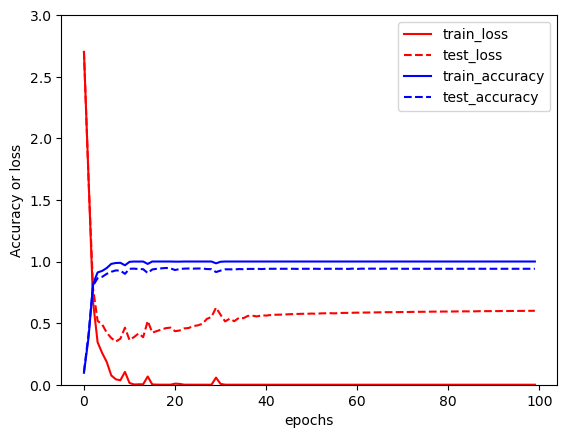

In [83]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_acc,
             "test_accuracy":test_acc})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

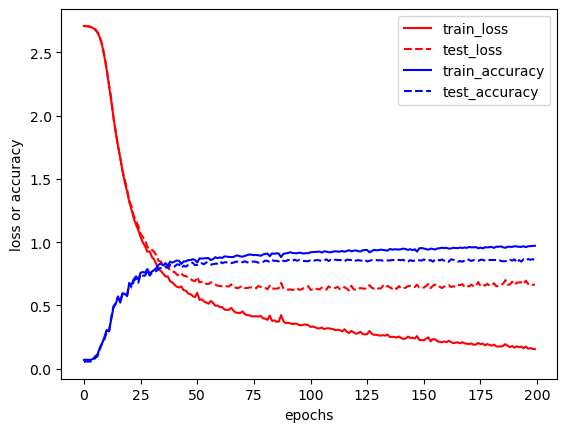

In [119]:
# # lossのグラフ化
# df_log = pd.DataFrame({"train_loss":train_loss,
#              "test_loss":test_loss,
#              "train_accuracy":train_acc,
#              "test_accuracy":test_acc})
# df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
# plt.ylabel("loss or accuracy")
# plt.xlabel("epochs")
# plt.show()

## 学習済みモデルの出力

In [84]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)

- Google Colab. を使用している人は `katakana_model.pickle` のダウンロードを忘れないようにしよう
  - 「識別精度算出ウェブサイト」への投稿に必要な情報であるため
  - ファイルダウンロードの参考：https://blog.kikagaku.co.jp/google-colab-file#_Google_Colab